<a href="https://colab.research.google.com/github/niigoatnightcord/595project/blob/main/Original_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/10], Loss: 0.6695065200328827
Epoch [2/10], Loss: 0.6427460312843323
Epoch [3/10], Loss: 0.6532391905784607
Epoch [4/10], Loss: 0.6296923905611038
Epoch [5/10], Loss: 0.634536474943161
Epoch [6/10], Loss: 0.6325835138559341
Epoch [7/10], Loss: 0.6161793619394302
Epoch [8/10], Loss: 0.6015581786632538
Epoch [9/10], Loss: 0.6070183664560318
Epoch [10/10], Loss: 0.5980250537395477
Test Accuracy: 34.0%


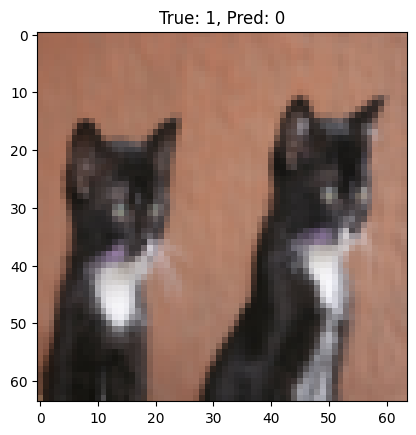

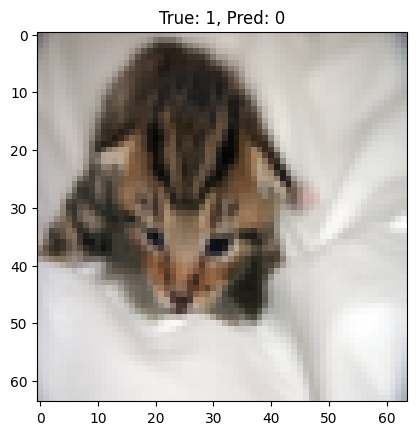

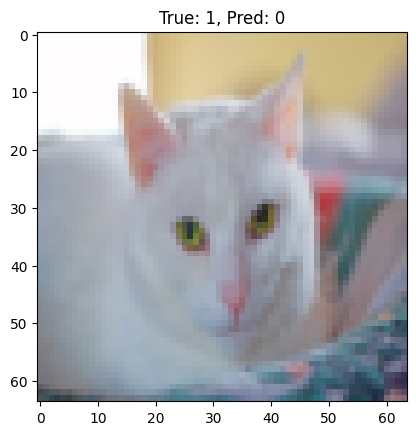

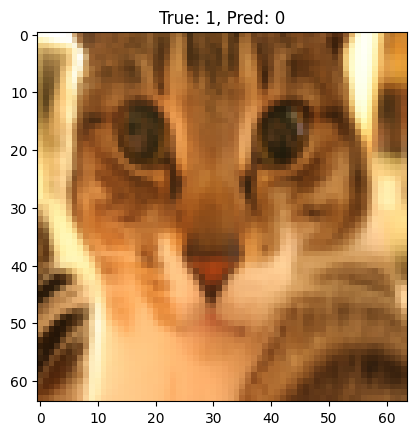

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

#load the dataset
train_data = h5py.File('train_catvnoncat.h5', 'r')
test_data = h5py.File('test_catvnoncat.h5', 'r')

#convert dataset to Numpy array
X_train = np.array(train_data['train_set_x'][:])  #img of train set
Y_train = np.array(train_data['train_set_y'][:])  # label of train set
X_test = np.array(test_data['test_set_x'][:])  # img of test set
Y_test = np.array(test_data['test_set_y'][:])  # label of test set

#normalize pixel value(range 0~255, 256 pixels)
X_train = X_train / 255.0
X_test = X_test / 255.0

# convert Numpy array to Pytorch tensor，permute (n, h, w, c) -> (n, c, h, w)
#n number of sample; h height; w width; c channel RGB=3
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

#convert label to Pytorch tensor
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)#int64
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# define custom dataset class
class CatVsNonCatDataset(Dataset):
    def __init__(self, X_data, Y_data):#nitialize the dataset with the provided features (X_data) and labels (Y_data)
        self.X_data = X_data#store the input data (features)
        self.Y_data = Y_data#store the labels corresponding to the input data

    def __len__(self):
        return len(self.X_data)#number of samples in the dataset

    def __getitem__(self, idx):#given an index, return the input data and label at that index
        return self.X_data[idx], self.Y_data[idx]

# Create DataLoader
train_dataset = CatVsNonCatDataset(X_train_tensor, Y_train_tensor)
test_dataset = CatVsNonCatDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()#call the parent class (nn.Module) constructor
        #first convolutional layer (conv1)
        #input channels (RGB images), outputs 32 channels, with a 3x3 kernel, stride 1, and padding 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        #second convolutional layer (conv2)
        #32 input channels (from conv1), outputs 64 channels, with a 3x3 kernel, stride 1, and padding 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #max pooling layer with a 2x2 pool size, reducing the size by half
        self.pool = nn.MaxPool2d(2, 2)

        #initialize variable for the fully connected layer input size
        self._to_linear = None
        #use nn.Sequential to chain the layers together
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),# ReLU activation function
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool
        )
        #compute the size of the output after the convolution and pooling layers
        self._get_conv_output_size((3, 64, 64))  # input img size is (3, 64, 64)

        #define the fully connected (linear) layers
        self.fc1 = nn.Linear(self._to_linear, 128)#first fully connected layer (128 units)
        self.fc2 = nn.Linear(128, 2)  #second fully connected layer (output layer for binary classification)

    def _get_conv_output_size(self, shape):
        """Calculate the output size after passing through convolutional and pooling layers."""
        o = self.convs(torch.zeros(1, *shape))# dummy input tensor to compute the output size of the convolutional layers
        #input shape (1, 3, 64, 64) for a batch of size 1
        self._to_linear = int(np.prod(o.size()))  #compute the total number of elements after convolution and pooling
        return self._to_linear
        return self._to_linear

    def forward(self, x):
        """Define the forward pass of the network."""
        x = self.convs(x)  #convolution layer
        x = x.reshape(x.size(0), -1)  #flatten the output from 2D to 1D for the fully connected layers
        x = torch.relu(self.fc1(x))#ReLU activation after the first fully connected layer
        x = self.fc2(x)#output layer, producing the final predictions (2 classes)
        return x

# Train the model
model = SimpleCNN()#create an instance of the SimpleCNN model
criterion = nn.CrossEntropyLoss()#loss function (Cross-Entropy Loss for classification)

#use the SGD optimizer with specified learning rate and momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
#loop through each epoch
for epoch in range(num_epochs):
    model.train()# set the model to training mode (important for layers like dropout or batch norm)
    running_loss = 0.0 # variable to accumulate the loss for each epoch
    #loop through the training data in batches (using train_loader)
    for inputs, labels in train_loader:
        optimizer.zero_grad()#zero the gradients to prevent accumulation from previous iterations
        outputs = model(inputs)#orward pass through the model to get predictions
        loss = criterion(outputs, labels)#Calculate the loss by comparing model outputs to the true labels
        loss.backward()#backpropagate the loss to compute gradients
        optimizer.step()#Update the model weights based on the gradients using the optimizer
        running_loss += loss.item()#add the current batch's loss to the running total

    #print the average loss for that epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# evaluate the model on the test set
model.eval()# Set the model to evaluation mode
correct = 0#count correctly classified images
total = 0#total num of img
misclassified_indices = []#list to store indices of misclassified images

with torch.no_grad():#dsable gradient calculation (faster and uses less memory during evaluation)
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)#forward pass to get model predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # track miscalssified img
        misclassified_indices.extend((predicted != labels).nonzero(as_tuple=True)[0].tolist())
#the accuracy of the model on the test set
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

#display misclassified img
misclassified_images = X_test_tensor[misclassified_indices[:4]]
misclassified_labels = Y_test_tensor[misclassified_indices[:4]]
misclassified_preds = torch.argmax(model(misclassified_images), dim=1)

for i in range(4):
    plt.imshow(misclassified_images[i].permute(1, 2, 0).numpy())
    plt.title(f"True: {misclassified_labels[i].item()}, Pred: {misclassified_preds[i].item()}")
    plt.show()
